# Neural Style Transfer

In [1]:
import numpy as np
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt

from IPython.display import display as display_fn
from IPython.display import Image, clear_output

## Utilities

In [2]:
def tensor_to_image(tensor):
    """converts a tensor to an image"""
    tensor_shape = tf.shape(tensor)
    number_elem_shape = tf.shape(tensor_shape)
    if number_elem_shape > 3:
        assert tensor_shape[0] == 1
        tensor = tensor[0]
    return tf.keras.preprocessing.image.array_to_img(tensor)


def load_img(path_to_img):
    """loads an image as a tensor and scales it to 512 pixels"""
    max_dim = 512
    image = tf.io.read_file(path_to_img)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)

    shape = tf.shape(image)[:-1]
    shape = tf.cast(tf.shape(image)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    image = tf.image.resize(image, new_shape)
    image = image[tf.newaxis, :]
    image = tf.image.convert_image_dtype(image, tf.uint8)

    return image


def load_images(content_path, style_path):
    """loads the content and path images as tensors"""
    content_image = load_img("{}".format(content_path))
    style_image = load_img("{}".format(style_path))

    return content_image, style_image


def imshow(image, title=None):
    """displays an image with a corresponding title"""
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)


def show_images_with_objects(images, titles=[]):
    """displays a row of images with corresponding titles"""
    if len(images) != len(titles):
        return

    plt.figure(figsize=(20, 12))
    for idx, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), idx + 1)
        plt.xticks([])
        plt.yticks([])
        imshow(image, title)


def clip_image_values(image, min_value=0.0, max_value=255.0):
    """clips the image pixel values by the given min and max"""
    return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)


def preprocess_image(image):
    """centers the pixel values of a given image to use with VGG-19"""
    image = tf.cast(image, dtype=tf.float32)
    image = tf.keras.applications.vgg19.preprocess_input(image)

    return image

## Images

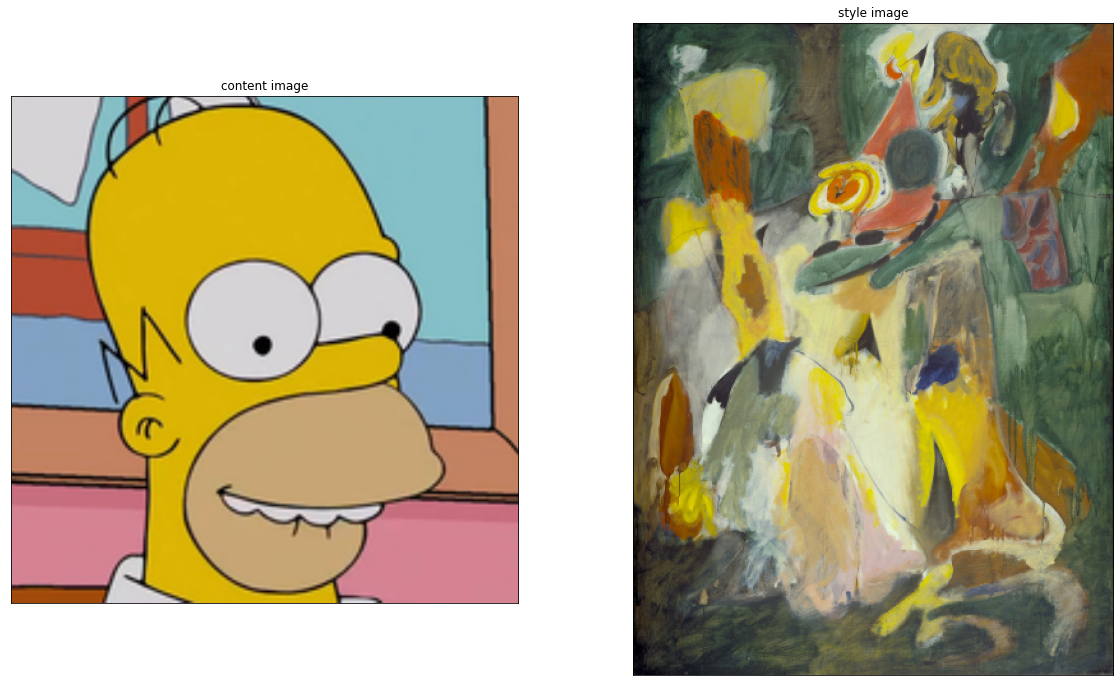

In [3]:
content_path = '../input/simpsons-faces/cropped/1.png'
style_path = '../input/abstract-art-gallery/Abstract_gallery/Abstract_gallery/Abstract_image_100.jpg'

content_image, style_image = load_images(content_path, style_path)
show_images_with_objects([content_image, style_image], titles=['content image', 'style image'])

# Build the model 

We will be using the VGG-19 model as the feature extractor. We will feed in the style and content image and depending on the computed losses, a new image will be generated which has elements of both the content and style image.

- For the style layers, we will use the first layer of each convolutional block.

- For the content layer, we will use the second convolutional layer of the last convolutional block (just one layer)

We will define a model to take the same input as the standard VGG-19 model, and output just the selected content and style layers.

<img src="https://drive.google.com/uc?export=view&id=1xNii3cDPob5cX8QpXPu3S3ps8s9O5X15" width="75%" height="75%"/>

In [4]:
style_layers = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layers = ["block5_conv2"]
output_layers = style_layers + content_layers

NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

In [5]:
def nst_model(layer_names):
    """Creates a vgg model that outputs the style and content layer activations.

    Args:
      layer_names: a list of strings, representing the names of the desired content and style layers

    Returns:
      A model that takes the regular vgg19 input and outputs just the content and style layers.

    """
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet")
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model(inputs=vgg.input, outputs=outputs)

    return model


In [6]:
K.clear_session()
model = nst_model(output_layers)
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

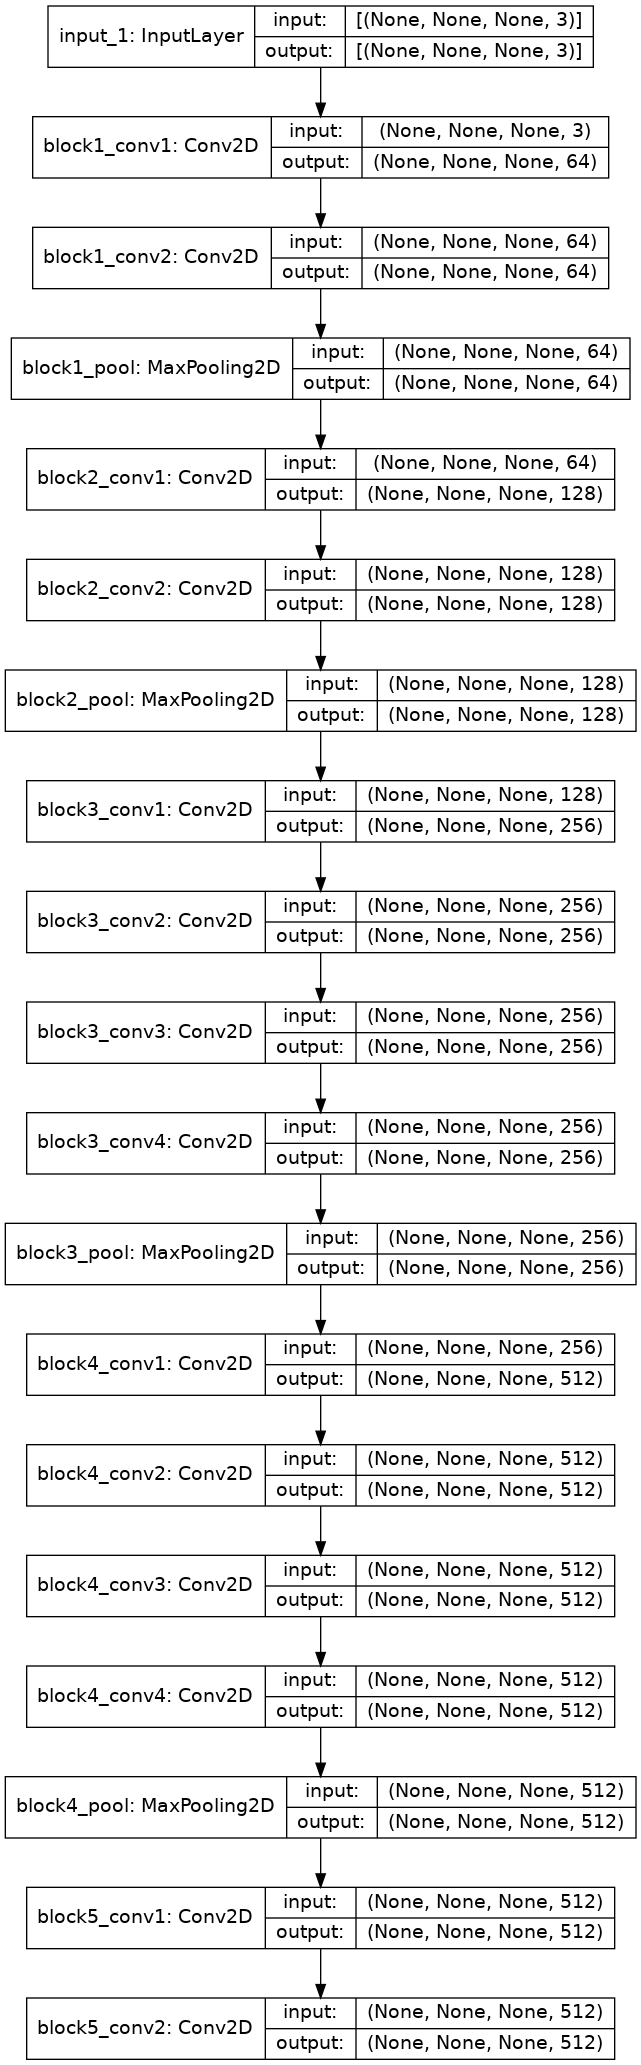

In [7]:
tf.keras.utils.plot_model(model, expand_nested=True, show_shapes=True)

# Define the loss functions

We will define functions to compute the losses required for generating the new image. These would be the:

* Style loss: the average of the squared differences between the features and targets
* Content loss: the sum of the squared error between the features and targets, then multiplied by a scaling factor (0.5)
* Total loss: combination of style and content loss $L_{total} = \beta L_{style} + \alpha L_{content}$

In [8]:
def get_style_loss(features, targets):
    """Expects two images of dimension h, w, c

    Args:
      features: tensor with shape: (height, width, channels)
      targets: tensor with shape: (height, width, channels)

    Returns:
      style loss (scalar)
    """
    style_loss = tf.reduce_mean(tf.square(features - targets))

    return style_loss


def get_content_loss(features, targets):
    """Expects two images of dimension h, w, c

    Args:
      features: tensor with shape: (height, width, channels)
      targets: tensor with shape: (height, width, channels)

    Returns:
      content loss (scalar)
    """
    content_loss = 0.5 * tf.reduce_sum(tf.square(features - targets))

    return content_loss

def gram_matrix(input_tensor):
    """Calculates the gram matrix and divides by the number of locations
    Args:
      input_tensor: tensor of shape (batch, height, width, channels)

    Returns:
      scaled_gram: gram matrix divided by the number of locations
    """

    gram = tf.linalg.einsum("bijc,bijd->bcd", input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    height = input_shape[1]
    width = input_shape[2]
    num_locations = tf.cast(height * width, tf.float32)
    scaled_gram = gram / num_locations

    return scaled_gram


def get_style_content_loss(
    style_targets,
    style_outputs,
    content_targets,
    content_outputs,
    style_weight,
    content_weight,
):
    """Combine the style and content loss

    Args:
      style_targets: style features of the style image
      style_outputs: style features of the generated image
      content_targets: content features of the content image
      content_outputs: content features of the generated image
      style_weight: weight given to the style loss
      content_weight: weight given to the content loss

    Returns:
      total_loss: the combined style and content loss

    """
    style_loss = tf.add_n(
        [
            get_style_loss(style_output, style_target)
            for style_output, style_target in zip(style_outputs, style_targets)
        ]
    )
    content_loss = tf.add_n(
        [
            get_content_loss(content_output, content_target)
            for content_output, content_target in zip(content_outputs, content_targets)
        ]
    )
    style_loss = style_loss * style_weight / NUM_STYLE_LAYERS
    content_loss = content_loss * content_weight / NUM_CONTENT_LAYERS
    total_loss = style_loss + content_loss

    return total_loss


# Get Content and Style Features

In [9]:
def get_style_image_features(image, model):
    """Get the style image features

    Args:
      image: an input image

    Returns:
      gram_style_features: the style features as gram matrices
    """
    preprocessed_style_image = preprocess_image(image)
    outputs = model(preprocessed_style_image)
    style_outputs = outputs[:NUM_STYLE_LAYERS]
    gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs]

    return gram_style_features


def get_content_image_features(image, model):
    """Get the content image features

    Args:
      image: an input image

    Returns:
      content_outputs: the content features of the image
    """
    preprocessed_content_image = preprocess_image(image)
    outputs = model(preprocessed_content_image)
    content_outputs = outputs[NUM_STYLE_LAYERS:]
    return content_outputs


# Generate the Styled Images

In [10]:
def update_image_with_style(
    image,
    style_targets,
    content_targets,
    style_weight,
    var_weight,
    content_weight,
    optimizer,
):
    """
    Args:
      image: generated image
      style_targets: style features of the style image
      content_targets: content features of the content image
      style_weight: weight given to the style loss
      content_weight: weight given to the content loss
      var_weight: weight given to the total variation loss
      optimizer: optimizer for updating the input image
    """
    gradients = calculate_gradients(
        image, style_targets, content_targets, style_weight, content_weight, var_weight
    )
    optimizer.apply_gradients([(gradients, image)])
    image.assign(clip_image_values(image, min_value=0.0, max_value=255.0))


def fit_style_transfer(
    style_image,
    content_image,
    style_weight=1e-2,
    content_weight=1e-4,
    var_weight=0,
    optimizer="adam",
    epochs=1,
    steps_per_epoch=1,
):
    """Performs neural style transfer.
    Args:
      style_image: image to get style features from
      content_image: image to stylize
      style_targets: style features of the style image
      content_targets: content features of the content image
      style_weight: weight given to the style loss
      content_weight: weight given to the content loss
      var_weight: weight given to the total variation loss
      optimizer: optimizer for updating the input image
      epochs: number of epochs
      steps_per_epoch = steps per epoch

    Returns:
      generated_image: generated image at final epoch
      images: collection of generated images per epoch
    """

    images = []
    step = 0
    style_targets = get_style_image_features(style_image, model)
    content_targets = get_content_image_features(content_image, model)
    generated_image = tf.cast(content_image, dtype=tf.float32)
    generated_image = tf.Variable(generated_image)
    images.append(content_image)
    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
            update_image_with_style(
                generated_image,
                style_targets,
                content_targets,
                style_weight,
                content_weight,
                var_weight,
                optimizer,
            )

            print(".", end="")

            if (m + 1) % 10 == 0:
                images.append(generated_image)

        clear_output(wait=True)
        display_image = tensor_to_image(generated_image)
        display_fn(display_image)

        images.append(generated_image)
        print("Train step: {}".format(step))
    generated_image = tf.cast(generated_image, dtype=tf.uint8)

    return generated_image, images


def calculate_gradients(
    image, style_targets, content_targets, style_weight, content_weight, var_weight
):
    """Calculate the gradients of the loss with respect to the generated image
    Args:
      image: generated image
      style_targets: style features of the style image
      content_targets: content features of the content image
      style_weight: weight given to the style loss
      content_weight: weight given to the content loss
      var_weight: weight given to the total variation loss

    Returns:
      gradients: gradients of the loss with respect to the input image
    """
    with tf.GradientTape() as tape:
        style_features = get_style_image_features(image, model)
        content_features = get_content_image_features(image, model)
        loss = get_style_content_loss(
            style_targets,
            style_features,
            content_targets,
            content_features,
            style_weight,
            content_weight,
        )
        loss += var_weight * tf.image.total_variation(image)
    gradients = tape.gradient(loss, image)

    return gradients


# Style Transfer

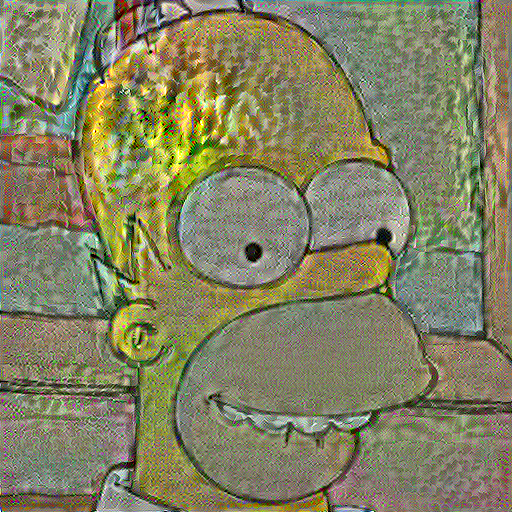

Train step: 1000


In [11]:
style_weight = 1e-4
content_weight = 1e-32
var_weight = 1e-2

adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=30.0, decay_steps=100, decay_rate=0.90
    )
)

stylized_image_reg, display_images_reg = fit_style_transfer(
    style_image=style_image,
    content_image=content_image,
    style_weight=style_weight,
    content_weight=content_weight,
    var_weight=var_weight,
    optimizer=adam,
    epochs=10,
    steps_per_epoch=100,
)

# Reference
[A Neural Algorithm of Artistic Style](https://arxiv.org/pdf/1508.06576.pdf)